*Structure*:

* data [ folder 'data' ] 
* scripts [ folder 'src' ] 

*Colormap of the notebook:*

* <span style="color:red">assignment problem</span>. The red color indicates the task that should be done
* <span style="color:green">debugging</span>. The green tells you what is expected outcome. Its primarily goal to help you get the correct answer
* <span style="color:blue">comments</span>.

Assignment 4 (Convolutional Neural Network)
======================



PyTorch supports many layer types, loss functions, and optimizers

* Layers: http://pytorch.org/docs/nn.html
* Activations: http://pytorch.org/docs/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/optim.html#algorithms

##### Preliminaries

In [1]:
# for compatability issues 
from __future__ import print_function

In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [3]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable

In [4]:
# to make interactive plotting possible
%matplotlib inline
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [5]:
# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

In [6]:
# random seed settings
torch.manual_seed(42)
np.random.seed(42)

# data type (useful to have in pytorch)
dtype_np = np.float64
dtype_torch = torch.FloatTensor
dtype_torch_cuda = torch.cuda.FloatTensor # to run on GPU

#### Load the data

In [7]:
from src.data_set import DataSetCifar10, DataSetDTD

In [8]:
!./data/get_cifar10_dataset.sh

/home/andrey/LDSSS2017/assigments/data
file exists


In [9]:
path_data = 'data' 

* Hyper-parameters

In [10]:
batch_size=100
learning_rate = 1e-2

In [11]:
data_set = DataSetCifar10(path_data, num_dunkeys=4, batch_size=batch_size)
#data_set = DataSetDTD(path_data, num_dunkeys=4, batch_size=100, fin_scale=32)

#### Helper functions

In [12]:
def make_test(data_loader, model_current, train_test, gpu=False):
    model.eval()
    correct = 0
    total = 0
    for images_, labels_ in data_loader[train_test]:
        
        if gpu:
            images_ = Variable(images_.type(dtype_torch_cuda), volatile=True)
            outputs_ = model_current(images_)
            _, predicted = torch.max(outputs_.data.cpu(), 1)
        else:
            images_ = Variable(images_)
            outputs_ = model_current(images_)
            _, predicted = torch.max(outputs_.data, 1)
            
        total += labels_.size(0)
        correct += (predicted == labels_).sum()
    print('accuracy[' + train_test + '] : %f %%' % (100 * correct / total))

Flatten function, which we explain here. Remember that our image data (and more relevantly, our intermediate feature maps) are initially N x C x H x W, where:
* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we input  data into fully connected affine layers, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "Flatten" operation to collapse the C x H x W values per representation into a single long vector.

In [13]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

#### define model

In [14]:
# Here's where we define the architecture of the model... 
first_model = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                Flatten(), # see above for explanation
                nn.Linear(5408, 10), # affine layer
              )

# Set the type of all data in this model to be FloatTensor 
first_model.type(dtype_torch)

Sequential (
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
  (1): ReLU (inplace)
  (2): Flatten (
  )
  (3): Linear (5408 -> 10)
)

In [15]:
model = copy.deepcopy(first_model).type(dtype_torch)

* Loss function

In [16]:
criterion = nn.CrossEntropyLoss().type(dtype_torch)

* define optimizer

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

* train the model

In [18]:
num_epochs = 1

In [19]:
# train
t = 0
logger = {}
logger['iteration'] = []
logger['loss_iteration'] = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_set.loader['train']):
        # get data to train
        images = Variable(images.type(dtype_torch))
        labels = Variable(labels.type(dtype_torch).long())

        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # reporting & logging
        logger['iteration'] += [t]
        logger['loss_iteration'] += [loss.data[0]]
        t += 1
        if t % 100 == 0:
            print('epoch: [%d/%d], step: [%d/%d], loss: %.4f' %
                   (epoch + 1, num_epochs, i+1, len(data_set.dataset['train'])//batch_size, loss.data[0]))
        
    print('--- epoch: [%d, %d]' % (epoch + 1, num_epochs))
    #make_test(data_set.loader, model, 'train')
    make_test(data_set.loader, model, 'test')

    # switch back to the training  mode
    model.train()

epoch: [1/1], step: [100/500], loss: 1.8933
epoch: [1/1], step: [200/500], loss: 1.5111
epoch: [1/1], step: [300/500], loss: 1.4503
epoch: [1/1], step: [400/500], loss: 1.5622
epoch: [1/1], step: [500/500], loss: 1.5233
--- epoch: [1, 1]
accuracy[test] : 47.270000 %


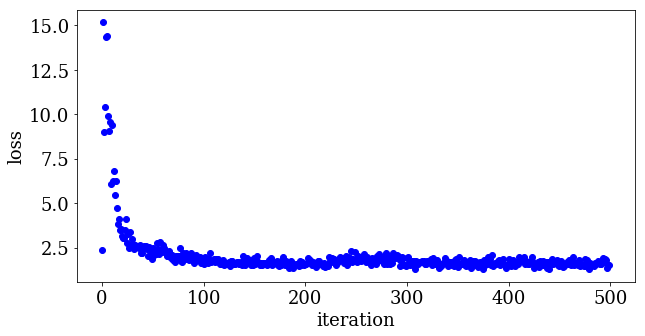

In [20]:
# visualize loss
plt.figure(figsize=(10,5))
plt.plot(logger['iteration'], logger['loss_iteration'],'ob', label="loss")

plt.xlabel('iteration')
plt.ylabel('loss');

#### GPU

In [21]:
# Verify that CUDA is properly configured and you have a GPU available
torch.cuda.is_available()

True

In [22]:
model_gpu = copy.deepcopy(model).type(dtype_torch_cuda)

In [23]:
# variable for CPU ( as usual )
x = torch.randn(128, 3, 32, 32).type(dtype_torch)
x_var = Variable(x.type(dtype_torch)) # Construct a PyTorch Variable out of your input data

# and now for GPU
x_gpu = torch.randn(128, 3, 32, 32).type(dtype_torch_cuda)
x_var_gpu = Variable(x.type(dtype_torch_cuda)) # Construct a PyTorch Variable out of your input data

In [24]:
%%timeit 
yyy = model(x_var)

100 loops, best of 3: 6.49 ms per loop


In [25]:
%%timeit 
torch.cuda.synchronize() # make sure there are no pending GPU computations
yyy = model_gpu(x_var_gpu) 
torch.cuda.synchronize() # make sure there are no pending GPU computations

The slowest run took 416.86 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 1.46 ms per loop


In [26]:
num_epochs = 10

In [27]:
criterion_gpu = nn.CrossEntropyLoss().type(dtype_torch_cuda)
optimizer_gpu = torch.optim.Adam(model_gpu.parameters(), lr=learning_rate)

In [28]:
# train gpu model
t = 0
logger = {}
logger['iteration'] = []
logger['loss_iteration'] = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_set.loader['train']):
        # get data to train
        images = Variable(images.type(dtype_torch_cuda))
        labels = Variable(labels.type(dtype_torch_cuda).long())

        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model_gpu.forward(images)
        loss = criterion_gpu(outputs, labels)
        loss.backward()
        optimizer_gpu.step()

        # reporting & logging
        logger['iteration'] += [t]
        logger['loss_iteration'] += [loss.data[0]]
        t += 1
        if t % 100 == 0:
            print('epoch: [%d/%d], step: [%d/%d], loss: %.4f' %
                   (epoch + 1, num_epochs, i+1, len(data_set.dataset['train'])//batch_size, loss.data[0]))
        
    print('--- epoch: [%d, %d]' % (epoch + 1, num_epochs))
    #make_test(data_set.loader, model_gpu, 'train')
    make_test(data_set.loader, model_gpu, 'test', gpu=True)

    # switch back to the training  mode
    model_gpu.train()

epoch: [1/10], step: [100/500], loss: 10661.1104
epoch: [1/10], step: [200/500], loss: 37117.7773
epoch: [1/10], step: [300/500], loss: 64515.1016
epoch: [1/10], step: [400/500], loss: 131198.7656
epoch: [1/10], step: [500/500], loss: 185517.4531
--- epoch: [1, 10]
accuracy[test] : 14.540000 %
epoch: [2/10], step: [100/500], loss: 327276.4688
epoch: [2/10], step: [200/500], loss: 253440.9531
epoch: [2/10], step: [300/500], loss: 314021.1875
epoch: [2/10], step: [400/500], loss: 275305.3750
epoch: [2/10], step: [500/500], loss: 441624.2500
--- epoch: [2, 10]
accuracy[test] : 17.030000 %
epoch: [3/10], step: [100/500], loss: 377274.1875
epoch: [3/10], step: [200/500], loss: 244484.3594
epoch: [3/10], step: [300/500], loss: 382759.9062
epoch: [3/10], step: [400/500], loss: 491383.5938
epoch: [3/10], step: [500/500], loss: 411129.1562
--- epoch: [3, 10]
accuracy[test] : 22.190000 %
epoch: [4/10], step: [100/500], loss: 707571.3750
epoch: [4/10], step: [200/500], loss: 511280.5312
epoch: [4

Using the code provided above as guidance, and using the following PyTorch documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs

And finally, set up a **cross-entropy** loss function and the **RMSprop** learning rule.

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [29]:
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
x = torch.randn(64, 3, 32, 32).type(dtype_torch)
x_var = Variable(x.type(dtype_torch)) # Construct a PyTorch Variable out of your input data
ans = new_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10])) 

NameError: name 'new_model' is not defined